In [10]:
import pandas as pd
from xgboost import XGBClassifier
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [19]:
!pip install seaborn --user

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


In [11]:
import re
import pandas as pd

def remove_ansi_codes(log_line):
    # Remove ANSI escape sequences
    return re.sub(r'\x1b\[[0-9;]*[a-zA-Z]', '', log_line)

def parse_logs_fixed(log_files):
    data = []
    for file in log_files:
        print(f"Processing file: {file}")
        with open(file, 'r') as f:
            for line in f:
                # Remove ANSI escape codes
                cleaned_line = remove_ansi_codes(line)
                
                # Extract relevant fields
                timestamp = re.search(r"\[\d{8}\s+\d{2}:\d{2}:\d{2}\]", cleaned_line)
                service = re.search(r"\]\s+(\w+)", cleaned_line)  # Service is the first word after timestamp
                message = re.search(r"(/dionaea/.*)", cleaned_line)

                # Append extracted data if all fields are present
                if timestamp and service and message:
                    data.append({
                        "timestamp": timestamp.group(0).strip("[]"),
                        "service": service.group(1),
                        "message": message.group(1)
                    })
    return pd.DataFrame(data)

In [12]:
def label_logs(df):
    def label(row):
        service = row['service'].lower()
        message = row['message'].lower()

        if 'http' in service or 'http' in message:
            if 'sql' in message or 'injection' in message:
                return 'SQL Injection'
            elif 'xss' in message or 'script' in message:
                return 'Cross-Site Scripting'
            else:
                return 'HTTP Attack'
        elif 'ftp' in service or 'ftp' in message:
            return 'FTP Attack'
        elif 'sip' in service or 'pptp' in service or 'pptp' in message:
            return 'SIP Attack'
        elif 'ssh' in service or 'brute' in message:
            return 'SSH Attack'
        elif 'dns' in service or 'dns' in message:
            return 'DNS Attack'
        elif 'log_sqlite' in service or 'log_sqlite' in message:
            return 'Log_SQLite Attack'
        elif 'download' in message or 'malware' in message:
            return 'Malware Download'
        else:
            return 'Other Attack'
    
    df['attack_type'] = df.apply(label, axis=1)
    return df



In [13]:
# Load the saved model and vectorizer
with open('xgboost_attack_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)


C:\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.2.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
# Parse new logs
new_log_files = ["logtest2.txt"]  # Replace with the path of the new log file
df_new = parse_logs_fixed(new_log_files)
df_new = label_logs(df_new)

# Vectorize the 'message' column of new logs
X_new = vectorizer.transform(df_new['message']).toarray()


Processing file: logtest2.txt


In [15]:
# Predict attack types for the new logs
y_new_pred = model.predict(X_new)

# Map encoded predictions back to attack type labels
attack_type_mapping = dict(enumerate(df_new['attack_type'].factorize()[1]))
df_new['predicted_attack_type'] = [attack_type_mapping[pred] for pred in y_new_pred]

# Display predictions
print("Predictions for New Logs:")
print(df_new[['timestamp', 'service', 'message', 'predicted_attack_type']])


Predictions for New Logs:
              timestamp   service  \
0     28012025 06:47:11      pptp   
1     28012025 06:47:11  services   
2     28012025 06:47:11      pptp   
3     28012025 06:47:11  services   
4     28012025 06:50:51      http   
...                 ...       ...   
1324  30012025 08:13:35      util   
1325  30012025 08:13:35      util   
1326  30012025 08:13:35      util   
1327  30012025 08:13:35      util   
1328  30012025 08:13:36      util   

                                                message predicted_attack_type  
0     /dionaea/pptp/pptp.py:52: No config provided. ...            SIP Attack  
1      /dionaea/services.py:46: Unable to start service          Other Attack  
2     /dionaea/pptp/pptp.py:52: No config provided. ...            SIP Attack  
3      /dionaea/services.py:46: Unable to start service          Other Attack  
4     /dionaea/http.py:133: max_num_fields is only s...           HTTP Attack  
...                                              

In [16]:
# Save the predictions to a CSV file
df_new.to_csv("xgboost_predicted_new_logs.csv", index=False)
print("Predictions saved to xgboost_predicted_new_logs.csv")


Predictions saved to xgboost_predicted_new_logs.csv


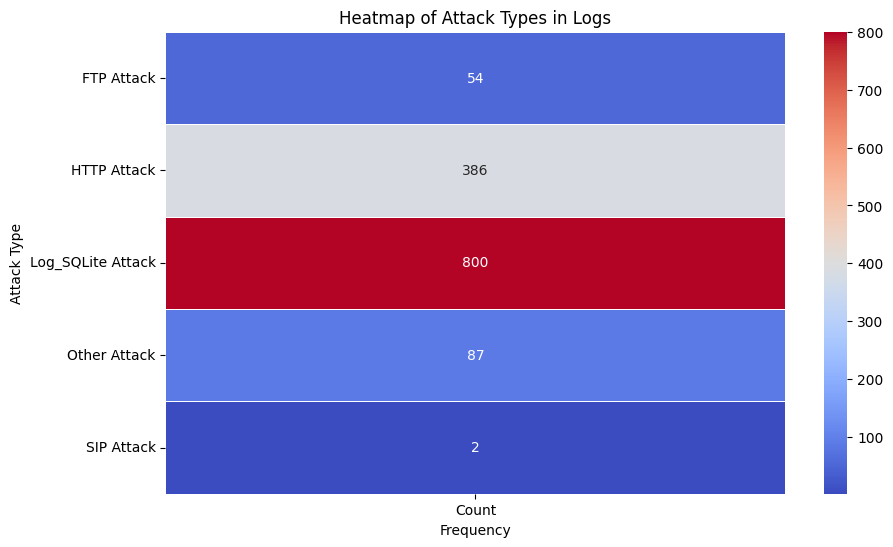

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the labeled logs dataset
df_labeled = pd.read_csv("xgboost_predicted_new_logs.csv")  # Ensure this file exists

# Count the occurrences of each attack type
attack_counts = df_labeled['attack_type'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Count']

# Pivot the data to create a heatmap-friendly format
heatmap_data = attack_counts.pivot_table(index="Attack Type", values="Count")

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="coolwarm", linewidths=0.5)

# Customization
plt.title("Heatmap of Attack Types in Logs")
plt.xlabel("Frequency")
plt.ylabel("Attack Type")
plt.show()
